# Recurrent Neural Network

## Part 1 - Data Preprocessing

### Importing the libraries

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

### Importing the training set

In [33]:
# use just the open values from the dataset
train_og = pd.read_csv('data\Google_Stock_Price_Train.csv')
train = train_og.loc[:, 'Open'].values
train

array([325.25, 331.27, 329.83, ..., 793.7 , 783.33, 782.75])

### Feature Scaling

In [34]:
# recommended to use normalization instead of standardization
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()

# reshape to 2d array
train = train.reshape(-1, 1)
train_sc = sc.fit_transform(train)
train_sc

array([[0.08581368],
       [0.09701243],
       [0.09433366],
       ...,
       [0.95725128],
       [0.93796041],
       [0.93688146]])

### Creating a data structure with 60 timesteps and 1 output

In [35]:
X_train=[]
y_train=[]

for timestamp in range(60, train_sc.shape[0]):
    y_train.append(train_sc[timestamp, 0])
    X_train.append(train_sc[timestamp-60: timestamp, 0]) #remember that the upper bound is excluded

#convert lists to arrays to use in the LSTM model.     
y_train = np.array(y_train)
X_train = np.array(X_train)

In [36]:
# sanity check
pd.DataFrame(X_train)

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,0.085814,0.097012,0.094334,0.091562,0.079842,0.064328,0.058542,0.065686,0.061091,0.066393,...,0.052143,0.056124,0.058189,0.065407,0.068830,0.072438,0.079935,0.078466,0.080345,0.084977
1,0.097012,0.094334,0.091562,0.079842,0.064328,0.058542,0.065686,0.061091,0.066393,0.061426,...,0.056124,0.058189,0.065407,0.068830,0.072438,0.079935,0.078466,0.080345,0.084977,0.086279
2,0.094334,0.091562,0.079842,0.064328,0.058542,0.065686,0.061091,0.066393,0.061426,0.074745,...,0.058189,0.065407,0.068830,0.072438,0.079935,0.078466,0.080345,0.084977,0.086279,0.084716
3,0.091562,0.079842,0.064328,0.058542,0.065686,0.061091,0.066393,0.061426,0.074745,0.027978,...,0.065407,0.068830,0.072438,0.079935,0.078466,0.080345,0.084977,0.086279,0.084716,0.074541
4,0.079842,0.064328,0.058542,0.065686,0.061091,0.066393,0.061426,0.074745,0.027978,0.023793,...,0.068830,0.072438,0.079935,0.078466,0.080345,0.084977,0.086279,0.084716,0.074541,0.078838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1193,0.934445,0.924939,0.921069,0.924381,0.930482,0.929905,0.931133,0.927506,0.944155,0.938760,...,0.931766,0.941141,0.957623,0.964134,0.964023,0.969715,0.950778,0.962944,0.961232,0.954759
1194,0.924939,0.921069,0.924381,0.930482,0.929905,0.931133,0.927506,0.944155,0.938760,0.934035,...,0.941141,0.957623,0.964134,0.964023,0.969715,0.950778,0.962944,0.961232,0.954759,0.952043
1195,0.921069,0.924381,0.930482,0.929905,0.931133,0.927506,0.944155,0.938760,0.934035,0.934835,...,0.957623,0.964134,0.964023,0.969715,0.950778,0.962944,0.961232,0.954759,0.952043,0.951633
1196,0.924381,0.930482,0.929905,0.931133,0.927506,0.944155,0.938760,0.934035,0.934835,0.931394,...,0.964134,0.964023,0.969715,0.950778,0.962944,0.961232,0.954759,0.952043,0.951633,0.957251


In [37]:
# sanity check
pd.DataFrame(y_train)

,0
0,0.086279
1,0.084716
2,0.074541
3,0.078838
4,0.072383
...,...
1193,0.952043
1194,0.951633
1195,0.957251
1196,0.937960


### Reshaping

In [38]:
# reshape to the input shape required by the RNN (see Keras documentation on RNN layers input shape).
# change the 3rd dimension if there are more indicators/features
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(1198, 60, 1)

## Part 2 - Building and Training the RNN

### Importing the Keras libraries and packages

In [39]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

### Initialising the RNN

In [40]:
rnn = Sequential()

### Adding the first LSTM layer and some Dropout regularisation

In [41]:
rnn.add(LSTM(units=50, return_sequences=True, input_shape = (X_train.shape[1], 1)))
# In the first layer we need to include the input shape. 
# The input shape is in 3d but we only need to input the 2 dimensions: timesteps and indicators. 
# The first dimension (number of observations) is automatically taken into account later.

In [42]:
rnn.add(Dropout(rate=0.2))

### Adding a second LSTM layer and some Dropout regularisation

In [43]:
rnn.add(LSTM(units = 50, return_sequences=True))
rnn.add(Dropout(rate=0.2))

### Adding a third LSTM layer and some Dropout regularisation

In [44]:
rnn.add(LSTM(units = 50, return_sequences=True))
rnn.add(Dropout(rate=0.2))

### Adding a fourth LSTM layer and some Dropout regularisation

In [45]:
rnn.add(LSTM(units = 50, return_sequences=False))
rnn.add(Dropout(rate=0.2))

### Adding the output layer

In [46]:
rnn.add(Dense(units=1))

In [47]:
rnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 60, 50)            10400     
                                                                 
 dropout_4 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_5 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_5 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_6 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_6 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_7 (LSTM)               (None, 50)               

### Compiling the RNN

In [48]:
#RMSProp is recommended by Keras as the optimizer for RNNs. We'll use Adam anyway.
rnn.compile(optimizer='Adam', loss='mean_squared_error')

### Fitting the RNN to the Training set

In [49]:
# Also specify a batch size here.
history = rnn.fit(x = X_train, y = y_train, batch_size=32, epochs=200)

Epoch 1/200
38/38 [==============================] - 5s 37ms/step - loss: 0.0306
Epoch 2/200
38/38 [==============================] - 1s 37ms/step - loss: 0.0053
Epoch 3/200
38/38 [==============================] - 1s 37ms/step - loss: 0.0051
Epoch 4/200
38/38 [==============================] - 1s 37ms/step - loss: 0.0051
Epoch 5/200
38/38 [==============================] - 1s 37ms/step - loss: 0.0049
Epoch 6/200
38/38 [==============================] - 1s 37ms/step - loss: 0.0046
Epoch 7/200
38/38 [==============================] - 1s 37ms/step - loss: 0.0050
Epoch 8/200
38/38 [==============================] - 1s 37ms/step - loss: 0.0046
Epoch 9/200
38/38 [==============================] - 1s 37ms/step - loss: 0.0046
Epoch 10/200
38/38 [==============================] - 1s 36ms/step - loss: 0.0042
Epoch 11/200
38/38 [==============================] - 1s 37ms/step - loss: 0.0039
Epoch 12/200
38/38 [==============================] - 1s 37ms/step - loss: 0.0039
Epoch 13/200
38/38 [=====

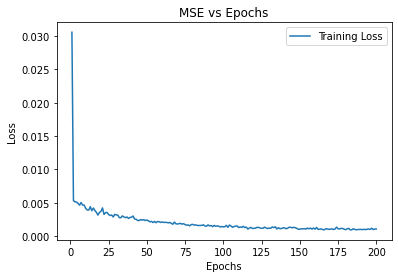

In [50]:
loss_values = history.history['loss']
epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('MSE vs Epochs')

plt.show()

## Part 3 - Making the predictions and visualising the results

### Getting the real stock price of 2017

In [51]:
# Import the test set
test_og = pd.read_csv('data\Google_Stock_Price_Test.csv')
test = test_og.loc[:, 'Open'].values
test

array([778.81, 788.36, 786.08, 795.26, 806.4 , 807.86, 805.  , 807.14,
       807.48, 807.08, 805.81, 805.12, 806.91, 807.25, 822.3 , 829.62,
       837.81, 834.71, 814.66, 796.86])

In [52]:
# Normalize the test set. 
# reshape to 2d array
test = test.reshape(-1, 1)

# just use transform - we want the scaler to be fit on the train data only.
test_sc = sc.transform(test)
y_test = test_sc
test_sc

array([[0.92955205],
       [0.94731751],
       [0.94307612],
       [0.96015329],
       [0.98087655],
       [0.98359253],
       [0.97827219],
       [0.98225314],
       [0.98288563],
       [0.98214153],
       [0.979779  ],
       [0.97849542],
       [0.98182528],
       [0.98245777],
       [1.01045465],
       [1.02407173],
       [1.03930724],
       [1.03354044],
       [0.99624228],
       [0.9631297 ]])

### Getting the predicted stock price of 2017

<AxesSubplot:xlabel='Date', ylabel='Open'>

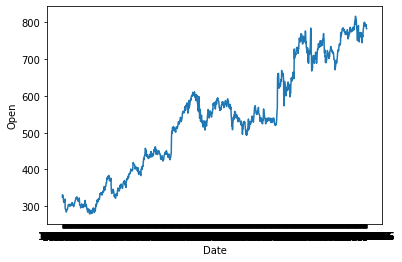

In [53]:
# plot of stock price in train set
sns.lineplot(x = train_og.Date, y = train_og.Open)

<AxesSubplot:xlabel='Date', ylabel='Open'>

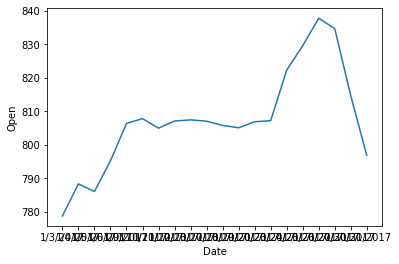

In [54]:
# plot of stock price in test set
sns.lineplot(x = test_og.Date, y = test_og.Open)

In [55]:
# for prediction we'll need values from both the train and the test set, as we'll have to look 60 days back. 
# concatenate the two arrays.
data_sc = np.concatenate((train_sc, test_sc))

# initialize X_test as an empty list
X_test = []

# store the index of where the test set begins
index_test = data_sc.shape[0] - test_sc.shape[0]

# create the data structure with the previous 60 observations to the current timestamp
for timestamp in range(index_test, data_sc.shape[0]):
    X_test.append(data_sc[timestamp-60: timestamp, 0])

# convert to array for the RNN
X_test = np.array(X_test)
y_test = np.array(y_test)

In [56]:
# sanity check
pd.DataFrame(X_test)

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,0.929905,0.931133,0.927506,0.944155,0.938760,0.934035,0.934835,0.931394,0.946369,0.965697,...,0.969715,0.950778,0.962944,0.961232,0.954759,0.952043,0.951633,0.957251,0.937960,0.936881
1,0.931133,0.927506,0.944155,0.938760,0.934035,0.934835,0.931394,0.946369,0.965697,0.975110,...,0.950778,0.962944,0.961232,0.954759,0.952043,0.951633,0.957251,0.937960,0.936881,0.929552
2,0.927506,0.944155,0.938760,0.934035,0.934835,0.931394,0.946369,0.965697,0.975110,0.959670,...,0.962944,0.961232,0.954759,0.952043,0.951633,0.957251,0.937960,0.936881,0.929552,0.947318
3,0.944155,0.938760,0.934035,0.934835,0.931394,0.946369,0.965697,0.975110,0.959670,0.978086,...,0.961232,0.954759,0.952043,0.951633,0.957251,0.937960,0.936881,0.929552,0.947318,0.943076
4,0.938760,0.934035,0.934835,0.931394,0.946369,0.965697,0.975110,0.959670,0.978086,1.000000,...,0.954759,0.952043,0.951633,0.957251,0.937960,0.936881,0.929552,0.947318,0.943076,0.960153
5,0.934035,0.934835,0.931394,0.946369,0.965697,0.975110,0.959670,0.978086,1.000000,0.980765,...,0.952043,0.951633,0.957251,0.937960,0.936881,0.929552,0.947318,0.943076,0.960153,0.980877
6,0.934835,0.931394,0.946369,0.965697,0.975110,0.959670,0.978086,1.000000,0.980765,0.970831,...,0.951633,0.957251,0.937960,0.936881,0.929552,0.947318,0.943076,0.960153,0.980877,0.983593
7,0.931394,0.946369,0.965697,0.975110,0.959670,0.978086,1.000000,0.980765,0.970831,0.984504,...,0.957251,0.937960,0.936881,0.929552,0.947318,0.943076,0.960153,0.980877,0.983593,0.978272
8,0.946369,0.965697,0.975110,0.959670,0.978086,1.000000,0.980765,0.970831,0.984504,0.960544,...,0.937960,0.936881,0.929552,0.947318,0.943076,0.960153,0.980877,0.983593,0.978272,0.982253
9,0.965697,0.975110,0.959670,0.978086,1.000000,0.980765,0.970831,0.984504,0.960544,0.937142,...,0.936881,0.929552,0.947318,0.943076,0.960153,0.980877,0.983593,0.978272,0.982253,0.982886


In [57]:
# sanity check
pd.DataFrame(y_test)

,0
0,0.929552
1,0.947318
2,0.943076
3,0.960153
4,0.980877
5,0.983593
6,0.978272
7,0.982253
8,0.982886
9,0.982142


In [58]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test.shape

(20, 60, 1)

In [59]:
y_pred = rnn.predict(X_test, batch_size=32)

In [60]:
# inverse the normalization
y_pred = sc.inverse_transform(y_pred)
y_pred

array([[796.95154],
       [794.4193 ],
       [801.4947 ],
       [800.00934],
       [806.0981 ],
       [815.2579 ],
       [816.3975 ],
       [813.9041 ],
       [816.2438 ],
       [817.68195],
       [817.7863 ],
       [817.0156 ],
       [816.74384],
       [818.42755],
       [818.89386],
       [830.6954 ],
       [836.61816],
       [842.3486 ],
       [839.9685 ],
       [825.16113]], dtype=float32)

### Visualising the results

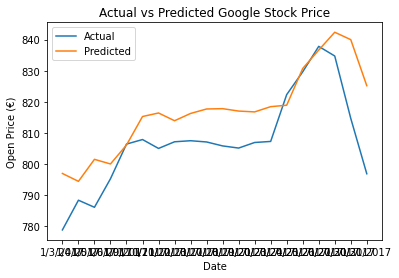

In [61]:
plt.plot(test_og.Date, test_og.Open, label='Actual')
plt.plot(test_og.Date, y_pred[:, 0], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Open Price (€)')
plt.legend()
plt.title('Actual vs Predicted Google Stock Price')

plt.show()

In [62]:
MSE = np.square(np.subtract(test_og.Open, y_pred[:, 0])).mean()
print('Mean Squared Error: ', MSE)

Mean Squared Error:  153.31310168310438
